In [1]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.17.2

     |███████████████████████████████▌| 834.1 MB 1.2 MB/s eta 0:00:11tcmalloc: large alloc 1147494400 bytes == 0x5601b4864000 @  0x7f2faa484615 0x56017b8234cc 0x56017b90347a 0x56017b8262ed 0x56017b917e1d 0x56017b899e99 0x56017b8949ee 0x56017b827bda 0x56017b899d00 0x56017b8949ee 0x56017b827bda 0x56017b896737 0x56017b918c66 0x56017b895daf 0x56017b918c66 0x56017b895daf 0x56017b918c66 0x56017b895daf 0x56017b828039 0x56017b86b409 0x56017b826c52 0x56017b899c25 0x56017b8949ee 0x56017b827bda 0x56017b896737 0x56017b8949ee 0x56017b827bda 0x56017b895915 0x56017b827afa 0x56017b895c0d 0x56017b8949ee
     |████████████████████████████████| 846.0 MB 22 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 82 kB 618 kB/s 
     |████████████████████████████████| 61 kB 6.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |█████████

# Model Selection, Underfitting, and Overfitting
# Polynomial Regression

In [1]:
import math
from mxnet import gluon, np, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

# Generating the Dataset

In [2]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
features[:2], poly_features[:2, :], labels[:2]

(array([[-0.03716067],
        [-1.1468065 ]]),
 array([[ 1.0000000e+00, -3.7160669e-02,  6.9045764e-04, -8.5526226e-06,
          7.9455290e-08, -5.9052235e-10,  3.6573678e-12, -1.9415747e-14,
          9.0187767e-17, -3.7238198e-19,  1.3837963e-21, -4.6747996e-24,
          1.4476556e-26, -4.1381425e-29,  1.0984010e-31, -2.7211542e-34,
          6.3199942e-37, -1.3815009e-39,  2.8516424e-42, -5.6051939e-45],
        [ 1.0000000e+00, -1.1468065e+00,  6.5758252e-01, -2.5137332e-01,
          7.2069131e-02, -1.6529869e-02,  3.1594271e-03, -5.1760738e-04,
          7.4199430e-05, -9.4547095e-06,  1.0842723e-06, -1.1304095e-07,
          1.0803007e-08, -9.5299690e-10,  7.8064499e-11, -5.9683248e-12,
          4.2778208e-13, -2.8857840e-14,  1.8385754e-15, -1.1097317e-16]]),
 array([ 5.1432443 , -0.06415121]))

# Training and Testing the Model

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(l.sum(), d2l.size(l))
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = gluon.loss.L2Loss()
    net = nn.Sequential()
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net.add(nn.Dense(1, use_bias=False))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': 0.01})
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data().asnumpy())

# [Third-Order Polynomial Function Fitting (Normal)]

weight: [[ 5.0190897  1.222048  -3.4236844  5.571709 ]]


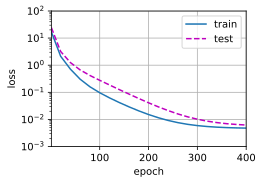

In [6]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

# [Linear Function Fitting (Underfitting)]

weight: [[2.7000637 4.2315993]]


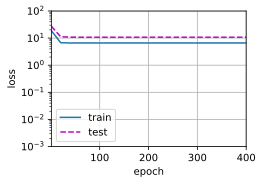

In [7]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

# [Higher-Order Polynomial Function Fitting (Overfitting)]

weight: [[ 4.9920163   1.3060642  -3.3531153   5.1165185  -0.11154564  1.3032213
   0.12670338  0.1665535   0.05128586 -0.02275132  0.00806116 -0.05167827
  -0.02426303 -0.01502207 -0.04941353  0.06389865 -0.04761845 -0.04380166
  -0.05188227  0.05655775]]


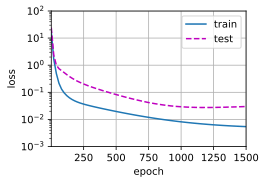

In [8]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)